In [23]:
import numpy as np
import torch
import dgl

from rdkit import Chem
from rdkit.Chem import AllChem
from tdc.single_pred import ADME

# 1. dataset

In [24]:
dataset = ADME(name = 'Solubility_AqSolDB')

Found local copy...
Loading...
Done!


In [25]:
split = dataset.get_split(
    method = 'random',
    seed = 42,
    frac=[0.7, 0.1, 0.2]
)

train_set = split['train']
valid_set = split['valid']
test_set = split['test']

In [26]:
smi_train = list(train_set['Drug'])
label_train = list(train_set['Y'])

# 2. Visualize molecules

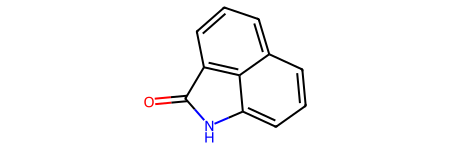

In [27]:
mol = Chem.MolFromSmiles(smi_train[0])
mol

# 3.Investigate how can we featurize molecular structure

### 1) Atom (node) features

    - atom symbol
    - Atom degree
    - Number of hydrogens attached to a given atom
    - Implicit valence
    - Whether a given atom has an aromatic character or not

In [28]:
atom_list = mol.GetAtoms()
num_atoms = len(atom_list)
atom_ = atom_list[0]

atom_symbol = atom_.GetSymbol()
atom_degree = atom_.GetDegree()
atom_hydrogens = atom_.GetTotalNumHs()
atom_implicit_valence = atom_.GetImplicitValence()
atom_is_aromatic = atom_.GetIsAromatic()

print(num_atoms)
print(atom_symbol)
print(atom_degree)
print(atom_hydrogens)
print(atom_implicit_valence)
print(atom_is_aromatic)

13
O
1
0
0
False


### 2) bond(edge) features

    - Bond types -- Single, Double, Triple, Aromatic
    - Wheter a given bond is conjugated or not
    - Whether a given bond has a ring character

In [29]:
bond_list = mol.GetBonds()
num_bonds = len(bond_list)
bond_ = bond_list[0]

bond_type = bond_.GetBondType()
bond_is_conj = bond_.GetIsConjugated()
bond_is_ring = bond_.IsInRing()

print(bond_type)
print(bond_is_conj)
print(bond_is_ring)

DOUBLE
True
False


# 4. Put them altogether -- define a series of functions that featurize molecular graph

In [30]:
ATOM_VOCAB = [
    'C', 'N', 'O', 'S', 'F',
    'H', 'Si', 'P', 'Cl', 'Br',
    'Li', 'Na', 'K', 'Mg', 'Ca',
    'Fe', 'As', 'Al', 'I', 'B',
    'V', 'Tl', 'Sb', 'Sn', 'Ag',
    'Pd', 'Co', 'Se', 'Ti', 'Zn',
    'Ge', 'Cu', 'Au', 'Ni', 'Cd',
    'Mn', 'Cr', 'Pt', 'Hg', 'Pb',
]

In [31]:
def one_of_k_encoding(x, vocab):
    if x not in vocab:
        x = vocab[-1]

    return list(map(lambda s : float(x==s), vocab))

In [37]:
def get_atom_feature(atom):
    atom_feature = one_of_k_encoding(atom.GetSymbol(), ATOM_VOCAB) # 만약 atom == c 이면 [1, 0, 0, 0, ...] 반환됨
    atom_feature += one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5])
    atom_feature += one_of_k_encoding(atom.GetTotalNumHs(), [0, 1, 2, 3, 4])
    atom_feature += one_of_k_encoding(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5])
    atom_feature += [atom.GetIsAromatic()]

    return atom_feature

In [33]:
def get_bond_feature(bond):
    bt = bond.GetBondType()
    bond_feature = [
        bt == Chem.rdchem.BondType.SINGLE,
        bt == Chem.rdchem.BondType.DOUBLE,
        bt == Chem.rdchem.BondType.TRIPLE,
        bt == Chem.rdchem.BondType.AROMATIC,
        bond.GetIsConjugated(),
        bond.IsInRing()
    ]

    return bond_feature

### DGLGraph 사용하기

dgl.DGLGraph() : 그래프 생성

graph.add_nodes( node_num:int ) : node_num 만큼 노드 생성

graph.ndata['key'] : 노드 특성을 저장하는 딕셔너리. 각 키는 노드 특성의 이름 / value는 tensor형태로 저장

graph.edata['key'] : 엣지 특성을 저장하는 딕셔너리. 각 키는 엣지 특성의 이름 / value는 tensor 형태로 저장

graph.add_edge(start_node_idx, end_node_idx) : 두 노드를 연결해줌



In [41]:
def get_molecular_graph(smi):
    mol = Chem.MolFromSmiles(smi)
    graph = dgl.DGLGraph()

    # atom 에대한 feature를 tensor로 만들어서 graph.ndata['h']에 저장
    atom_list = mol.GetAtoms()
    num_atoms = len(atom_list)
    graph.add_nodes(num_atoms) # atom 개수 만큼 노드 추가

    atom_feature_list = [get_atom_feature(atom) for atom in atom_list] # [[1, 0, ...], ... (atom 개수만큼)]
    atom_feature_tensor = torch.tensor(atom_feature_list, dtype=torch.float64) # 위 리스트를 tensor로 바꾸네
    graph.ndata['h'] = atom_feature_tensor 


    # bond에 대한 feature를 tensor로 만들어서 graph.edata['e_ij']에 저장
    bond_list = mol.GetBonds()
    bond_feature_list = []

    for bond in bond_list:
        bond_feature = get_bond_feature(bond) # [1, 0, 0 ,0 ,0 ] 과 같은 값 반환 : bond type에 따라 1값이 하나 있는 onehot

        src = bond.GetBeginAtom().GetIdx()
        dest = bond.GetEndAtom().GetIdx()
        
        # i --> j
        graph.add_edges(src, dest)
        bond_feature_list.append(bond_feature)

        # j --> i
        graph.add_edges(dest, src)
        bond_feature_list.append(bond_feature)

    bond_feature_tensor = torch.tensor(bond_feature_list, dtype=torch.float64) 
    graph.edata['e_ij'] = bond_feature_tensor
    return graph


In [42]:
smi_ = smi_train[-1]
g_ = get_molecular_graph(smi_)

# GNN Practice

# 1. GCN, GIN and GIN + E

In [43]:
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl.nn.functional import edge_softmax

In [45]:
print(g_.ndata['h'].shape)
print(g_.edata['e_ij'].shape)

torch.Size([11, 64])
torch.Size([22, 6])


In [47]:
## 차원을 맞추기 위한 embedding node 와 embedding edge

embedding_node = nn.Linear(64, 64, bias=False)
embedding_edge = nn.Linear(6, 64, bias=False)

h0 = embedding_node(g_.ndata['h'].float()) # [11, 64] # tensor로 표현된 화합물을 구성하는 원소들
g_.ndata['h'] = h0 # [64, 64]

e_ij = embedding_edge(g_.edata['e_ij'].float()) # [22, 6]
g_.edata['e_ij'] = e_ij # [22, 64]

## 1) Graph Convolution

#### u_ : sum aggregation of the adjacent node features

In [49]:
g_.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'u_'))  # 연결 된 것을 sum 연산해서 노드 tensor를 업데이트
u_ = g_.ndata['u_']
u_.shape

torch.Size([11, 64])

#### Applying linear layer, non-linear activation, layer normalization, and dropout

In [50]:
linear_ = nn.Linear(64, 64, bias=False)
norm_ = nn.LayerNorm(64)
act_ = F.relu
prob_ = 0.2

In [51]:
h_ = linear_(u_)
h_ = act_(h_) + h0
h_ = norm_(h_)
h_ = F.dropout(h_, p=prob_, training=False)

In [ ]:
# g_.ndata['h'] = h_ # 업데이트 하는 부분인데 다른 실습해야 해서 실행은 안함.

## 2) Graph Isomorphism

In [61]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, bias=True, act=F.relu):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.act = act

        self.linear1 = nn.Linear(input_dim, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, output_dim, bias=bias)

    def forward(self, h):
        h = self.linear1(h)
        h = self.act(h)
        h = self.linear2(h)
        return h

In [60]:
g_.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'u_'))
u_ = g_.ndata['u_']
u_.shape

torch.Size([11, 64])

In [63]:
mlp_ = MLP(
    input_dim=64,
    hidden_dim = 64 * 4,
    output_dim = 64
)
norm_ = nn.LayerNorm(64)
act_ = F.relu
prob_ = 0.2

In [65]:
h_ = mlp_(u_)
h_ = act_(h_) + h0
h_ = norm_(h_)
h_ = F.dropout(h_, p=prob_, training=False)

## 3) Graph Isomorphism w/ edge features

In [66]:
g_.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'u_'))
u_ = g_.ndata['u_']
u_.shape

torch.Size([11, 64])

In [92]:
g_.update_all(fn.copy_e('e_ij', 'm_e'), fn.sum('m_e', 'e_'))

print(g_.edata['e_ij'].shape)
print(g_.ndata['e_'].shape)
print(g_.ndata['u_'].shape)

torch.Size([22, 64])
torch.Size([11, 64])
torch.Size([11, 64])


In [79]:
h_ = g_.ndata['u_'] + g_.ndata['e_']
h_ = mlp_(u_)
h_ = act_(h_) + h0
h_ = F.dropout(h_, p=prob_, training=False)

In [88]:
import dgl
import torch
import dgl.function as fn

# 그래프 생성
g = dgl.graph((torch.tensor([0, 1]), torch.tensor([1, 2])))

# 엣지 데이터 설정
g.edata['e_ij'] = torch.tensor([[1, 0, 1, 0], [0, 1, 1, 0]], dtype=torch.float32)

# update_all 함수 적용
g.update_all(fn.copy_e('e_ij', 'm_e'), fn.sum('m_e', 'e_'))

# 결과 출력
print(g.edata['e_ij'])
print(g.ndata['e_'])


tensor([[1., 0., 1., 0.],
        [0., 1., 1., 0.]])
tensor([[0., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 1., 0.]])


In [5]:
import dgl
import torch
import dgl.function as fn

# 간단한 그래프 생성
u, v = torch.tensor([0, 1, 2]), torch.tensor([1, 2, 3])
g = dgl.graph((u, v))

# 노드 특징 정의
g.ndata['h'] = torch.tensor([[1., 2.], [3., 4.], [5., 6.], [7., 8.]])

# 엣지 데이터 업데이트
g.apply_edges(fn.u_add_v('h', 'h', 'e'))

print(g.edata['e'])


tensor([[ 4.,  6.],
        [ 8., 10.],
        [12., 14.]])


In [11]:
import torch 
import torchvision
import torchtext

torch.__version__, torchvision.__version__, torchtext.__version__

('2.3.0', '0.18.1', '0.18.0')

In [12]:
a = torch.tensor([1, 2, 3, 4]).to("mps")
a

tensor([1, 2, 3, 4], device='mps:0')

In [13]:
torch.backends.mps.is_available()

True